In [1]:
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.sql import sql_raw
from siuba.experimental import completer

## Are often do feeds lack a feed_end_date?

In [2]:
tbl_daily_feed = (
    tbl.views.gtfs_schedule_fact_daily_feeds()
    >>mutate(missing_date = _.date.isna())
    >>count(_.date)
    )

In [3]:
tbl_daily_feeds_enriched = (tbl.views.gtfs_schedule_fact_daily_feeds()
  >> inner_join(_, tbl.views.gtfs_schedule_dim_feeds(), "feed_key")
)

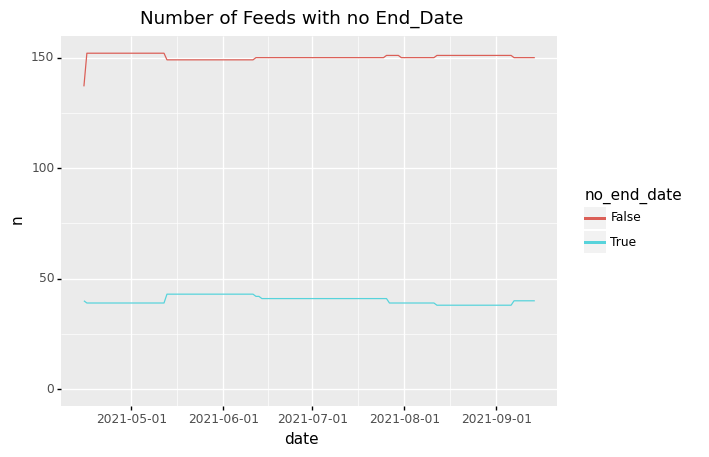

<ggplot: (8770696784336)>

In [4]:
(tbl.views.gtfs_schedule_fact_daily_feeds()
  >> inner_join(_, tbl.views.gtfs_schedule_dim_feeds(), "feed_key")
  >> count(_.date, no_end_date = _.feed_end_date.isna())
  >> collect()
  >> mutate(date = _.date.astype("datetime64[ns]"))
  >> ggplot(aes("date", "n", color = "no_end_date")) + geom_line() + expand_limits(y = 0) + ggtitle("Number of Feeds with no End_Date")

)

# What is the max calendar end date? (calculated max service end date per date, feed key)

In [5]:
tbl_feeds_service = (
    tbl.views.gtfs_schedule_fact_daily_service()
    >>group_by(_.calitp_itp_id, _.calitp_url_number)
    >>mutate(
        max_service_date = (_.service_date.max())
    )
)

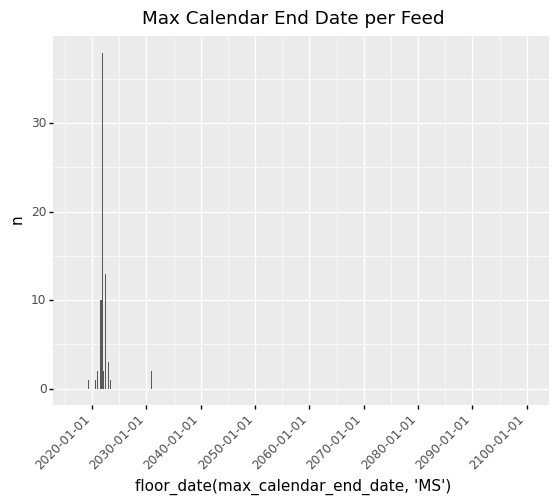

<ggplot: (8770675586551)>

In [6]:
from siuba.experimental.datetime import floor_date

tbl_calendar_max = (
    tbl.gtfs_schedule_type2.calendar_clean()
    >> filter(_.calitp_extracted_at <= "2021-08-01", _.calitp_deleted_at > "2021-08-01")
    >> group_by(_.calitp_itp_id, _.calitp_url_number)
    >> summarize(max_calendar_end_date = _.end_date.max())
)

(tbl_calendar_max
    >> collect()
    >> mutate(max_calendar_end_date = _.max_calendar_end_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("floor_date(max_calendar_end_date, 'MS')", "n" )) + geom_col() + ggtitle("Max Calendar End Date per Feed") + theme(axis_text_x=element_text(angle=45, hjust=1))
)

In [7]:
tbl_end_date_joined = tbl_daily_feeds_enriched >> filter(_.date == "2021-08-01") >> inner_join(_, tbl_calendar_max, ["calitp_itp_id", "calitp_url_number"])

In [8]:
tbl_end_date_filtered = (
    tbl_end_date_joined 
    >> filter(_.feed_end_date.isna()) 
    >> collect() >> arrange(_.max_calendar_end_date) 
    >> select(_.calitp_feed_name, _.max_calendar_end_date)
)

In [9]:
#commented out to avoid generating csv
# tbl_end_date_filtered.to_csv('calitp_max_calendar_end_date.csv')

# On today, what percentage of feeds lack feed_end_date? 

In [10]:
 tbl_filt = (
  tbl.views.gtfs_schedule_fact_daily_feeds()
  >> inner_join(_, tbl.views.gtfs_schedule_dim_feeds(), "feed_key")
  >> filter(_.date == "2021-09-14")
  >> count(_.date, no_end_date = _.feed_end_date.isna())
  >> collect()
)



In [11]:
tbl_filt_percent = ((tbl_filt['n']/tbl_filt['n'].sum()) *100).round()

In [12]:
#percentage of feeds that lack feed_end_dates for September 14, rounded up by 2 decimals 
tbl_filt_percent.iloc[1]

21.0

In [13]:
tbl_end_date_joined_today = tbl_daily_feeds_enriched >> filter(_.date == "2021-09-14") >> inner_join(_, tbl_calendar_max, ["calitp_itp_id", "calitp_url_number"])

In [14]:
tbl_end_date_filtered = (
    tbl_end_date_joined_today 
    >> filter(_.feed_end_date.isna()) 
    >> collect() >> arrange(_.max_calendar_end_date) 
    >> select(_.calitp_feed_name, _.max_calendar_end_date)
)

In [15]:
tbl_end_date_filtered

,calitp_feed_name,max_calendar_end_date
34,Yolobus (0),2017-02-01
27,Folsom Stage Line (0),2019-05-30
5,Tri-Valley Wheels (0),2020-09-06
3,San Diego Metropolitan Transit System (0),2021-06-07
31,SamTrans (0),2021-06-19
23,Gold Coast Transit (0),2021-07-24
28,MUNI (0),2021-08-13
35,Metro (1),2021-08-14
19,Glendale Beeline (0),2021-08-15
10,Golden Gate Bridge Highway and Transportation ...,2021-09-11
